In [39]:
import numpy as np
import pandas as pd
import random

def decide(probs=None, utils=None):
    if probs is None and utils is None:
        raise ValueError("Either 'probs' or 'utils' must be given")

    if utils is None:
        if len(probs.shape) > 1:
            raise ValueError("'probs' is not a vector, please specify array of utilities")
        utils = np.diag(probs)

    elif probs is None:
        probs = np.full(utils.shape[1], 1/utils.shape[1])

    if len(probs) != utils.shape[1]:
        raise ValueError('Mismatch between inference and utility variates')

    if not isinstance(utils, pd.DataFrame):
        utils = pd.DataFrame(utils)

    # Calculate expected utilities (matrix product)
    exputils = np.dot(utils, probs)
    # If expected utilites are the same for every class, choose random class
    # if(len(set(exputils)) == 1):
    #     exputils = pd.Series(exputils, index=utils.index).sort_values(ascending=False)
    #     return {'EUs': exputils, 'optimal': random.randint(0,len(exputils)-1)}

        
    exputils = pd.Series(exputils, index=utils.index).sort_values(ascending=False)
    #Select one decision with max expected utility
    optimal = exputils.idxmax()
    return {'EUs': exputils, 'optimal': optimal}

    

# Example usage
probs = np.array([0.5, 0.5])
utils = np.array([[1, 0], [-1,2]])
result = decide(probs=probs, utils=utils)
print(result)


{'EUs': 0    0.5
1    0.5
dtype: float64, 'optimal': 0}


In [40]:
def utilityMatrixCreator(minUtil, maxUtil):
    U_AA = random.randint(minUtil if minUtil > 0 else 0, maxUtil)
    U_BA = random.randint(minUtil-1, U_AA-1)

    U_BB = random.randint(minUtil if minUtil > 0 else 0, maxUtil)
    U_AB = random.randint(minUtil-1, U_BB-1)
    return [[U_AA, U_AB], [U_BA, U_BB]]

In [41]:
np.array(utilityMatrixCreator(-10, 10))

array([[ 7,  2],
       [-9,  3]])

In [42]:
# Probabilities from RNopm infer
prob_predict_cat = [0.976039626021315, 0.0239603739786851]
prob_predict_dog = [0.00717048738691545, 0.992829512613085]


In [43]:
CM_df = pd.read_csv('cd_dataframe.csv')

In [44]:
CM_df.head()

,Unnamed: 0,True Cat,True Dog
0,Predicted Cat,1744,38
1,Predicted Dog,6,1712


In [45]:
CM = np.array([[1744, 38], [6, 1712]])

In [46]:
util = np.array(utilityMatrixCreator(-10, 10))

In [47]:
expected_RN = np.multiply(CM, util)
expected_RN = expected_RN.sum()

In [48]:
test_df = pd.read_csv('test_dataframe.csv')

In [49]:
cm_rn = np.array([[0, 0], [0, 0]]) 

In [50]:
def func_expected_opm(df,util, cm):
    expected_opm = 0
    number_of_overrides = 0

    for index, row in df.iterrows():
        predicted = row['Predicted']
        actual = row['Actual']

        if predicted == 'dog':
            optimal = decide(prob_predict_dog, util).get("optimal")
            
            if optimal == 1:
                if 'dog' == actual: #RPopm did not override and resnet predicted dog and it was dog
                    expected_opm += util[1][1]
                    cm[1][1] += 1
                else:   #RPopm did not override and resnet predicted dog and but it was cat
                    expected_opm += util[1][0]
                    cm[1][0] += 1
            else:
                number_of_overrides += 1
                if 'cat' == actual: #RPopm override and guessed cat and it was cat
                    expected_opm += util[0][0] 
                    cm[0][0] += 1  
                else: #RPopm override and guessed cat and but it was dog
                    expected_opm += util[0][1]
                    cm[0][1] += 1
        else:
            optimal = decide(prob_predict_cat, util).get("optimal")

            if optimal == 0:
                if 'cat' == actual: #RPopm did not override and resnet predicted cat and it was cat
                    expected_opm += util[0][0]
                    cm[0][0] += 1
                else:   #RPopm did not override and resnet predicted cat and but it was dog
                    expected_opm += util[0][1]
                    cm[0][1] += 1
            else:
                number_of_overrides += 1
                if 'dog' == actual: #RPopm override and guessed dog and it was dog
                    expected_opm += util[1][1]  
                    cm[1][1] += 1
                else: #RPopm override and guessed dog and but it was cat
                    expected_opm += util[1][0]
                    cm[1][0] += 1

    return expected_opm, number_of_overrides

## Trivial utility-matrix

In [51]:
util

array([[5, 2],
       [4, 9]])

In [71]:
CM

array([[1744,   38],
       [   6, 1712]])

In [72]:
cm_rn

array([[1750, 1750],
       [   0,    0]])

In [52]:
print(f'Expected utilities with resnet alone: {np.multiply(CM, util).sum()}')
expected_opm = func_expected_opm(test_df, util, cm_rn)
print(f"Expected utilities with OPM: {expected_opm[0]}, total number over overrides {expected_opm[1]}")

Expected utilities with resnet alone: 24228


Expected utilities with OPM: 24228, total number over overrides 0


In [53]:
resnetUtil = []
opmUtil = []
for i in range(100):
    util = np.array(utilityMatrixCreator(-10, 10))
    expected_opm = func_expected_opm(test_df, util, cm_rn)
    rsnetUtil = np.multiply(CM, util).sum()
    resnetUtil.append(rsnetUtil)
    opmUtil.append(expected_opm[0])


In [54]:
import matplotlib.pyplot as plt

C:\Users\47472\AppData\Local\Temp\ipykernel_15740\1541215544.py:12: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(True)


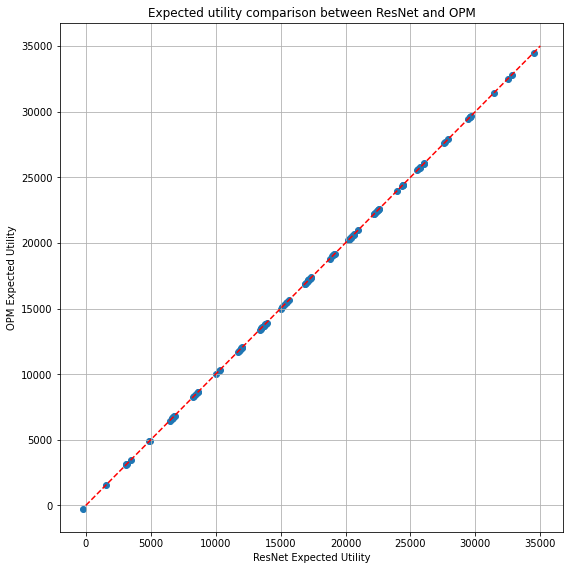

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(resnetUtil, opmUtil)
x = [0, 35000]  # Adjust the range based on your needs
y = [0, 35000]  # Adjust the range based on your needs

# Plot the red dotted diagonal line
plt.plot(x, y, 'r--')
plt.grid(True)
plt.title("Expected utility comparison between ResNet and OPM")
plt.xlabel("ResNet Expected Utility")
plt.ylabel("OPM Expected Utility")
plt.tight_layout(True)
# plt.legend(["Diagonal dotted line", "Scatter plot"])
plt.savefig('demo.JPEG', transparent=False)



In [56]:
CM

array([[1744,   38],
       [   6, 1712]])

In [57]:
cm_rn

array([[176144,   3838],
       [   606, 172912]])

## Slightly above threshold(p)

In [58]:
cm_rn = np.array([[0, 0], [0, 0]]) 

In [59]:
def p_threshold(U_AA, U_AB, U_BA, p):
    p = U_AB + (U_AA - U_BA)*((p)/(1-p))
    return [[U_AA, U_AB], [U_BA, p]]

In [60]:
u_above = np.array(p_threshold(1.,0., 0, 0.98)) #utility matrix using slightly above threshold(p)

In [61]:
u_above

array([[ 1.,  0.],
       [ 0., 49.]])

In [62]:
print(f'Expected utilities with resnet alone: {np.multiply(CM, u_above).sum()}')
expected_opm = func_expected_opm(test_df, u_above, cm_rn)
print(f"Expected utilities with OPM: {expected_opm[0]}, total number over overrides {expected_opm[1]}")

Expected utilities with resnet alone: 85631.99999999993
Expected utilities with OPM: 85749.99999999999, total number over overrides 1782


In [63]:
CM

array([[1744,   38],
       [   6, 1712]])

In [64]:
cm_rn #confusion matrix 

array([[   0,    0],
       [1750, 1750]])

## Slightly below threshold(p)

In [65]:
cm_rn = np.array([[0, 0], [0, 0]]) 

In [66]:
u_below = np.array(p_threshold(1.,-1 , 1, 0.95)) #utility matrix using sligthly below threshold(p)

In [67]:
u_below

array([[ 1., -1.],
       [ 1., -1.]])

In [68]:
print(f'Expected utilities with resnet alone: {np.multiply(CM, u_below).sum()}')
expected_opm = func_expected_opm(test_df, u_below, cm_rn)
print(f"Expected utilities with OPM: {expected_opm[0]}, total number over overrides {expected_opm[1]}")

Expected utilities with resnet alone: 0.0
Expected utilities with OPM: 0.0, total number over overrides 1718


In [69]:
CM

array([[1744,   38],
       [   6, 1712]])

In [70]:
cm_rn

array([[1750, 1750],
       [   0,    0]])